# Clustering and differential expression analysis using scVI-tools

In [1]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import json
import anndata
import scvi
import os

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'E175'
data_out_path = './data/{}/scvi-tools/'.format(dataset_name)
default_path = '{}default/'.format(data_out_path)
celltypist_path = '{}celltypist/'.format(data_out_path)
nclusters_celltypist_path = './data/{}/nclusters.json'.format(dataset_name)

top_number_of_markers = 500
min_cluster_size = 0

with open(nclusters_celltypist_path) as f:
    nclusters_celltypist = json.load(f)['nclusters']

nclusters_threshold = 1/10
min_ncluster_celltypist = round(nclusters_celltypist - nclusters_threshold*nclusters_celltypist)
max_ncluster_celltypist = round(nclusters_celltypist + nclusters_threshold*nclusters_celltypist)

if not os.path.exists(default_path):
    os.makedirs(default_path)

if not os.path.exists(celltypist_path):
    os.makedirs(celltypist_path)

## Data loading and preparation

Dataset loading 

In [3]:
adata = sc.read_csv(f'./data/{dataset_name}/CorticalCells_GSM2861514_E175_cleaned.csv', first_column_names=None)
adata = adata.T
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 874 × 17085

Studying feature variance

/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_1376/1806452391.py:3: RuntimeWarning: divide by zero encountered in log
  sorted_log_variances = [np.log(-i) for i in neg_variances.T][:2000]


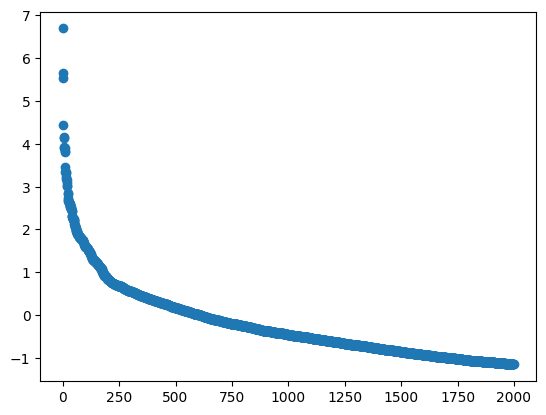

In [4]:
matrix = adata.X
neg_variances = np.sort(-np.var(matrix, axis=0))
sorted_log_variances = [np.log(-i) for i in neg_variances.T][:2000]
plt.scatter([i for i in range(len(sorted_log_variances))], sorted_log_variances)

Data normalization

In [5]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

Feature selection

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


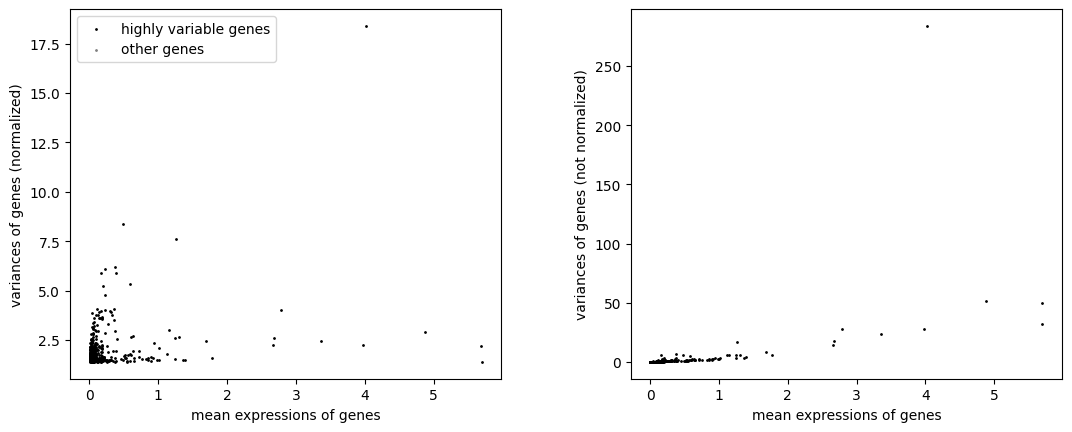

In [6]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=500, # chosen based on elbow plot above
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pl.highly_variable_genes(adata)

## Model training

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
)

model = scvi.model.SCVI(adata)
model.train(use_gpu=False)
model

I0000 00:00:1707901957.149751       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=10). Se

Epoch 400/400: 100%|██████████| 400/400 [00:24<00:00, 16.46it/s, v_num=1, train_loss_step=123, train_loss_epoch=124] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [00:24<00:00, 16.32it/s, v_num=1, train_loss_step=123, train_loss_epoch=124]


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

## Clustering

Save latent representation

In [8]:
latent = model.get_latent_representation()
adata.obsm["X_scVI"] = latent
adata.layers["scvi_normalized"] = model.get_normalized_expression()

Plot pca explained variance ratio to choose number of components

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


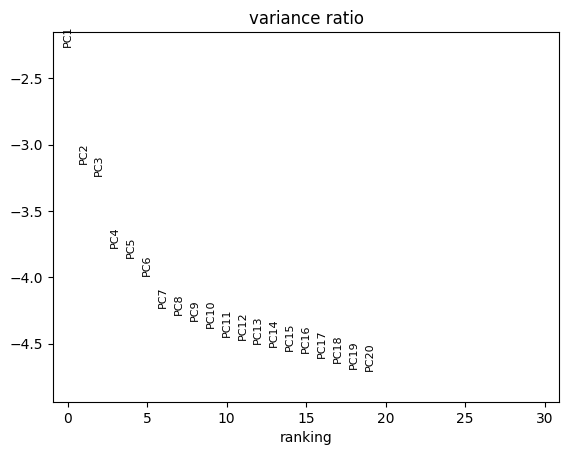

In [9]:
sc.tl.pca(adata, svd_solver="arpack", n_comps=20, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

### Clustering with default parameters

Perform the clustering

In [10]:
sc.pp.neighbors(
    adata,
    n_pcs=10, # chosen based on elbow plot above
    use_rep="X_scVI"
)
sc.tl.leiden(adata, key_added="leiden_scVI")

Visualize the clustering in the PCA space

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


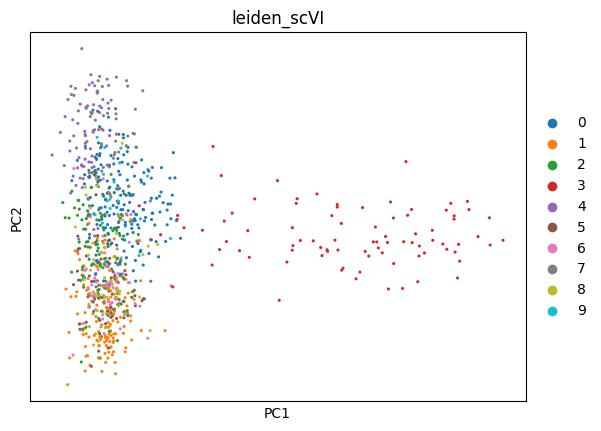

In [11]:
sc.pl.pca(
    adata,
    color=["leiden_scVI"],
    size=20,
)

Save the clustering results

In [12]:
default_markers_df = pd.DataFrame(adata.obs['leiden_scVI'])
default_markers_df = default_markers_df.rename(columns={'leiden_scVI': 'cluster'})
default_markers_df.index.names = ['cell']
default_markers_df['cluster'] = default_markers_df['cluster'].astype(int) + 1
default_markers_df.to_csv(default_path+'clustering_labels.csv')
default_num_clusters = len(default_markers_df['cluster'].unique())

## Differential expression on default clusters

Perform the differential expression analysis

In [13]:
default_de_df = model.differential_expression(
    groupby="leiden_scVI",
)

DE...: 100%|██████████| 10/10 [00:00<00:00, 10.49it/s]


Save markers

In [14]:
default_markers = {}
default_cats = adata.obs.leiden_scVI.cat.categories
for i, c in enumerate(default_cats):
    cell_type_df = default_de_df.loc[default_de_df.group1 == c]
    # if uncommented there are not enough genes
    #cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    #cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]
    default_markers[c] = cell_type_df.sort_values('lfc_mean', ascending=False).index.tolist()[:top_number_of_markers]

default_makers_df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for i in range(default_num_clusters):
    tmp_list = [ [default_markers[str(i)][j], i, j] for j in range(top_number_of_markers)]
    tmp_df = pd.DataFrame(tmp_list, columns=['gene', 'cluster', 'rank'])
    deafult_makerks_df = pd.concat([default_makers_df, tmp_df],  ignore_index=True)

deafult_makerks_df['cluster'] += 1
deafult_makerks_df['rank'] += 1
deafult_makerks_df.to_csv(default_path+'markers.csv', index=False)


### Clustering tuning resolution according to celltypist

In [15]:
print("Nummber of clusters to find: {}".format(nclusters_celltypist))

Nummber of clusters to find: 26


Perform the clustering

In [16]:
sc.pp.neighbors(
    adata,
    n_pcs=10, # chosen based on elbow plot above
    use_rep="X_scVI"
)
sc.tl.leiden(adata, key_added="leiden_scVI")

max_resolution = 3
min_resolution = 0

while True:
    resolution = (max_resolution + min_resolution)/2
    print("Trying resolution: {}".format(resolution))
    sc.tl.leiden(adata, key_added="leiden_scVI", resolution=resolution)
    num_clusters = adata.obs.leiden_scVI.values.categories.nunique()
    print("Number of clusters found: {}".format(num_clusters))

    if num_clusters >= min_ncluster_celltypist and num_clusters <= max_ncluster_celltypist:
        break
    elif num_clusters <  min_ncluster_celltypist:
        min_resolution = resolution
    else:
        max_resolution = resolution

Trying resolution: 1.5
Number of clusters found: 16
Trying resolution: 2.25
Number of clusters found: 21
Trying resolution: 2.625
Number of clusters found: 27


Visualize the clustering in the PCA space

/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/irenetesta/anaconda3/envs/chl/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


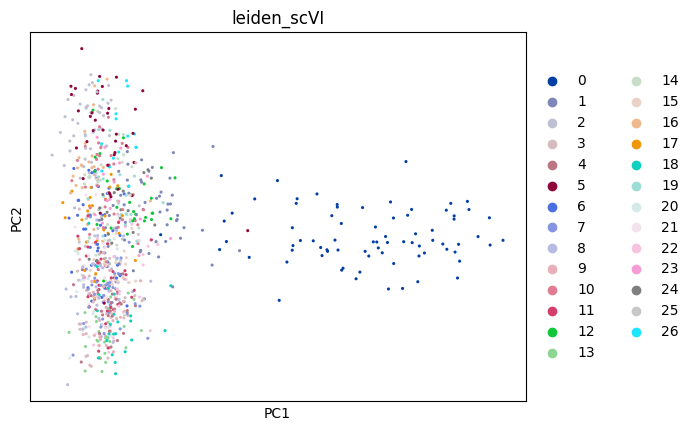

In [17]:
sc.pl.pca(
    adata,
    color=["leiden_scVI"],
    size=20,
)

Save the clustering results

In [18]:
celltypist_markers_df = pd.DataFrame(adata.obs['leiden_scVI'])
celltypist_markers_df = celltypist_markers_df.rename(columns={'leiden_scVI': 'cluster'})
celltypist_markers_df.index.names = ['cell']
celltypist_markers_df['cluster'] = celltypist_markers_df['cluster'].astype(int) + 1
celltypist_markers_df.to_csv(celltypist_path+'clustering_labels.csv')
celltypist_num_clusters = len(celltypist_markers_df['cluster'].unique())

## Differential expression on clusters tuned according to celltypist

Perform the differential expression analysis

In [19]:
celltypist_de_df = model.differential_expression(
    groupby="leiden_scVI",
)

DE...: 100%|██████████| 27/27 [00:02<00:00, 10.07it/s]


Save markers

In [23]:
celltypist_markers = {}
cats = adata.obs.leiden_scVI.cat.categories
for i, c in enumerate(cats):
    cell_type_df = celltypist_de_df.loc[celltypist_de_df.group1 == c]
    # if uncommented there are not enough genes
    #cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 3]
    #cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]
    celltypist_markers[c] = cell_type_df.sort_values('lfc_mean', ascending=False).index.tolist()[:top_number_of_markers]

celltypist_markers_df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])
for i in range(celltypist_num_clusters):
    tmp_list = [ [celltypist_markers[str(i)][j], i, j] for j in range(top_number_of_markers)]
    tmp_df = pd.DataFrame(tmp_list, columns=['gene', 'cluster', 'rank'])
    celltypist_markers_df = pd.concat([celltypist_markers_df, tmp_df],  ignore_index=True)

celltypist_markers_df['cluster'] += 1
celltypist_markers_df['rank'] += 1
celltypist_markers_df.to_csv(celltypist_path+'markers.csv', index=False)